# EEG Data Analysis

This project is about recording brain signals of 35 people while performing arithmetic tasks and at rest. These signals were recorded at rest (1) and during arithmetic test (2). Filenames can be distinguished. The edf format(European Data Format) is designed for the exchange and storage of medical time data. data was collected via EEG(Electroencephalography). The electrical activity waves that occur in the brain are recorded with the EEG. 




## Importing Library

First of all, helper libraries to be used in code need to be added to Python. Libraries are codes that collection of functions and class

1-) **glob**: The recorded signals consist of 70 files with .edf extension. The glob module in python was used to be able to read these files. Glob module helps to list specific files in folder.

2-) **os**: The os module provides support for using files and folders between operating systems.

3-) **mne**: It is a python package that allows working with EEG and MEG data. It allows to read EEG data.

4-) **numpy**: Numpy is a library that facilitates mathematical operations on large arrays and arrays.

5-) **pandas**: Pandas is used to process, analyze and manipulate data.

6-) **matplotlib.pyplot**: It is used to visualize data.

In [1]:
from glob import glob
import os # linux veya windows dizinleri için
import mne # Open;-source Python package for exploring, visualizing, and analyzing human neurophysiological data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.metrics import confusion_matrix


First,  the files in the folder are imported into our working environment with the glob module mentioned above. Test was done with the first index(0) to see the file names.

In [2]:
all_file_path=glob('C://Users//deneme//Desktop//Bitirme//eeg-during-mental-arithmetic-tasks-1.0.0//*.edf') # list şeklinde
all_file_path[0]

'C://Users//deneme//Desktop//Bitirme//eeg-during-mental-arithmetic-tasks-1.0.0\\Subject00_1.edf'

As mentioned earlier, people's data was divided into two: at rest and during testing. In order to classify these files, the data was listed by taking the 1 and 2 numbers in the file names with the split method. The len() function is applied to see the lengths of the lists. The length of lists are same. 

In [3]:
before_test=[i for i in all_file_path if '1' in i.split('_')[1]]
during_test=[i for i in all_file_path if '2' in i.split('_')[1]]
print(len(before_test),len(during_test))



36 36


##  Sample Data

In order to examine the contents of the edf extension file with the mne library imported above, the sample data was read. In this process, io.read_raw_edf() function in the mne library is used. In order to be able to index the data faster, the memory was preloaded with the preload parameter. 

In [4]:
data1=mne.io.read_raw_edf(before_test[4],preload=True)
data2=mne.io.read_raw_edf(during_test[4],preload=True)


Extracting EDF parameters from C:\Users\deneme\Desktop\Bitirme\eeg-during-mental-arithmetic-tasks-1.0.0\Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84999  =      0.000 ...   169.998 secs...
Extracting EDF parameters from C:\Users\deneme\Desktop\Bitirme\eeg-during-mental-arithmetic-tasks-1.0.0\Subject04_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


It were checked length of both data by len() function. As can be seen, before_test data is longer than during_test data.

When the data of different people were checked, it was observed that the data were of different sizes. In general, it can be said to be 91000-31000 long.

In [5]:
print(len(data1),len(data2))

85000 31000


In the code below, the general information of the data was observed.

This information includes upper and lower frequency limits, number of channels, filename and processing time. 

It has been determined that the high pass and low pass values vary for different people.



In [6]:
data1

<RawEDF | Subject04_1.edf, 21 x 85000 (170.0 s), ~13.6 MB, data loaded>

In [7]:
data2

<RawEDF | Subject04_2.edf, 21 x 31000 (62.0 s), ~5.0 MB, data loaded>

In the code below, the data can be seen graphically.

Using matplotlib as 2D backend.


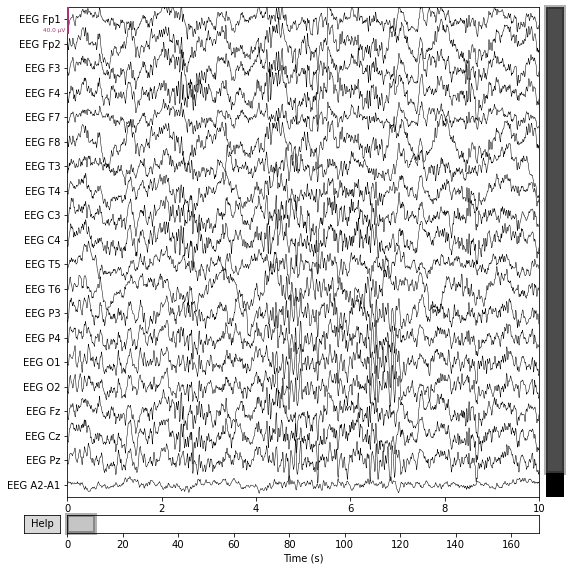

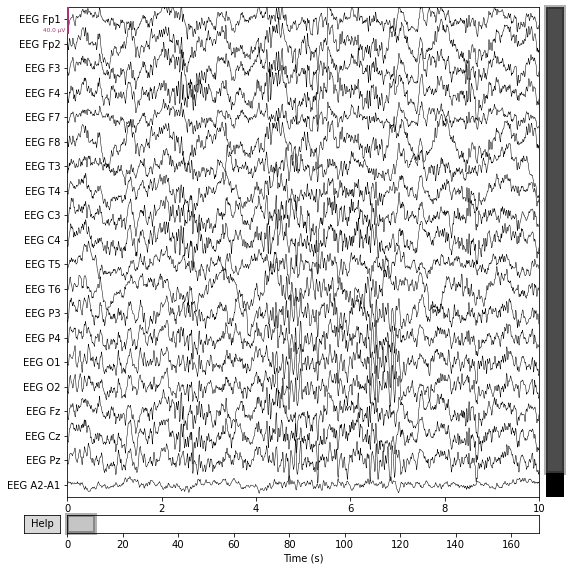

In [8]:
data1.plot()

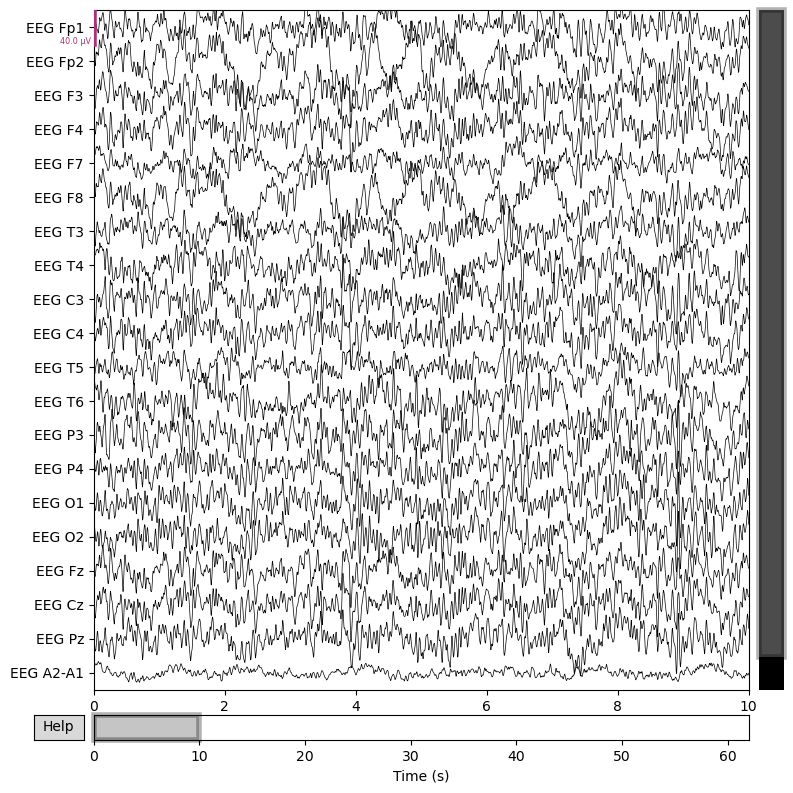

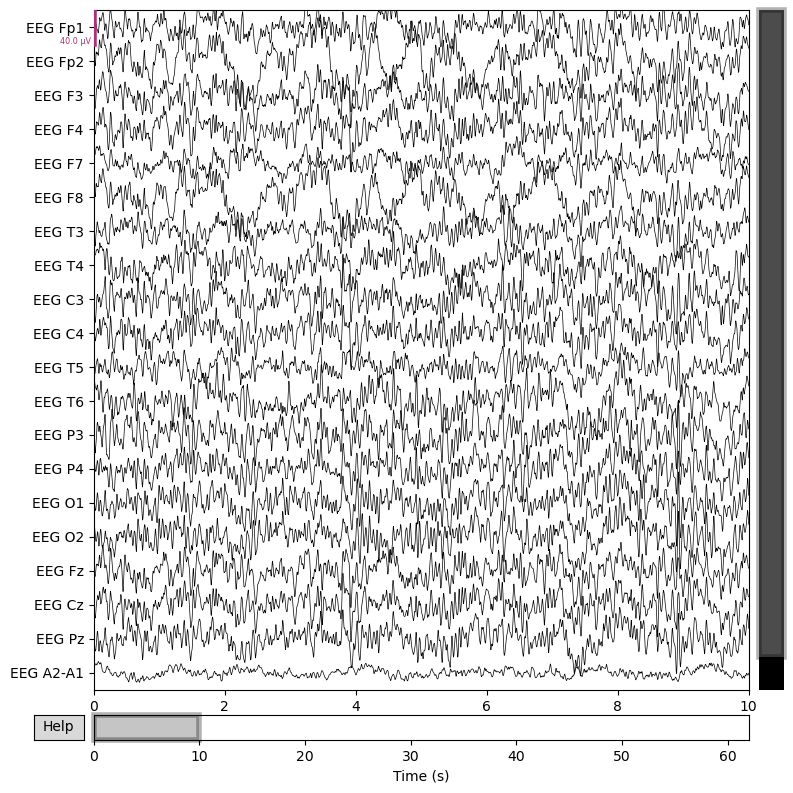

In [9]:
data2.plot()

 ## read_data function
 
After examining the sample person's data, the read_data function was created to read all people's data in a single function. The details of this function are as follows;
 
 1-) **mne.io.read_raw_edf**:For reading files process, io.read_raw_edf() function in the mne library is used.
 
 2-) **data.filter**: This function determines the maximum and minimum frequency values in the data of individuals and brings the frequencies within this range.
 
 3-) **mne.make_fixed_length_epochs**: In the function, the data is split into 5 second chunks and the length of overlap between chunks is 1 second.
  
 4-) **epochs.get_data()**: This function converts data to array format.
 
 

In [87]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter

def read_data(before,during,model):
    data_before=mne.io.read_raw_edf(before,preload=True)
    data_before.filter(l_freq=0,h_freq=45)
    epochs_before=mne.make_fixed_length_epochs(data_before,duration=5,overlap=1) # Divide continuous raw data into equal-sized consecutive epochs.
    array_before=epochs_before.get_data()# to_array..in some cases the to_data_frame function can be used
    label_array_before= len(array_before)*[0]
    
    data_during=mne.io.read_raw_edf(during,preload=True)
    data_during.filter(l_freq=0,h_freq=45)
    epochs_during=mne.make_fixed_length_epochs(data_during,duration=5,overlap=1) # Divide continuous raw data into equal-sized consecutive epochs.
    array_during=epochs_during.get_data()
    label_array_during= len(array_during)*[1]
    
    array_data = np.vstack((array_before,array_during))
    array_label = np.hstack((label_array_before, label_array_during))
    a,b,c=array_data.shape
    array_data_shape=array_data.reshape(a,b*c)
    array_label_shape=array_label.ravel()
    pca = PCA(n_components = 0.97)
    pca.fit(array_data_shape)
    array_data_shape = pca.transform(array_data_shape)
    
    X_train, X_test, y_train, y_test = train_test_split(array_data_shape, array_label_shape, test_size = 0.2)
    print(Counter(y_test))

    
    if(model=='LR'):
        logisticRegr = LogisticRegression(solver = 'liblinear')
        logisticRegr.fit(X_train,y_train)
        y_pred=logisticRegr.predict(X_test)
        logisticRegr.score(X_test, y_test)

        y_pred = logisticRegr.predict(X_test)
        return confusion_matrix(y_test,y_pred)
    
    elif(model=='SVM'):
        model = SVC(kernel='rbf',C=2.0)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        return confusion_matrix(y_test,y_pred)
    
    

In [88]:
x=read_data(before_test[30],during_test[30],'LR')

y=read_data(before_test[30],during_test[30],'SVM')



Extracting EDF parameters from C:\Users\deneme\Desktop\Bitirme\eeg-during-mental-arithmetic-tasks-1.0.0\Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 147 samples (0.294 sec)

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished


0 bad epochs dropped
Extracting EDF parameters from C:\Users\deneme\Desktop\Bitirme\eeg-during-mental-arithmetic-tasks-1.0.0\Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 147 samples (0.294 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s finished


Counter({0: 11, 1: 1})
Extracting EDF parameters from C:\Users\deneme\Desktop\Bitirme\eeg-during-mental-arithmetic-tasks-1.0.0\Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 147 samples (0.294 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\deneme\Desktop\Bitirme\eeg-during-mental-arithmetic-tasks-1.0.0\Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 147 samples (0.294 sec)



[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s finished


Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
Counter({0: 10, 1: 2})


In [89]:
x

array([[11,  0],
       [ 1,  0]], dtype=int64)

As a result of the function created above, the data of a person was examined. Before_test_array and during_test_array lists are created and added to all people with the help of comprehension.

In [90]:
y

array([[9, 1],
       [2, 0]], dtype=int64)